In [15]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import Image
import PIL.Image as pil
import pickle

Extracting features of query image:

In [16]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [17]:
upImgs1 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
dataBatch1 = upImgs1[b'data']

upImgs2 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_2")
dataBatch2 = upImgs2[b'data']

upImgs3 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_3")
dataBatch3 = upImgs3[b'data']

upImgs4 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
dataBatch4 = upImgs4[b'data']

upImgs5 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
dataBatch5 = upImgs5[b'data']

meta_data = unpickle("E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\batches.meta")

test_batchUpImgs = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\test_batch")
test_batch = test_batchUpImgs[b'data']

In [18]:
datasetImgs = np.append(dataBatch1, dataBatch2, axis=0)
datasetImgs = np.append(datasetImgs, dataBatch3, axis=0)
datasetImgs = np.append(datasetImgs, dataBatch4, axis=0)
datasetImgs = np.append(datasetImgs, dataBatch5, axis=0)
print(datasetImgs, datasetImgs.shape)
print(type(datasetImgs))

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]] (50000, 3072)
<class 'numpy.ndarray'>


In [19]:
print(datasetImgs[0, ], datasetImgs[0, ].shape) # first image in batch1 of dataset

[ 59  43  50 ... 140  84  72] (3072,)


In [20]:
print(dataBatch1, dataBatch1.shape)
print(dataBatch1[0, ], dataBatch1[0, ].shape)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]] (10000, 3072)
[ 59  43  50 ... 140  84  72] (3072,)


In [21]:
print(dataBatch5, dataBatch5.shape)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]] (10000, 3072)


In [22]:
print(test_batch, test_batch.shape)

[[158 159 165 ... 124 129 110]
 [235 231 232 ... 178 191 199]
 [158 158 139 ...   8   3   7]
 ...
 [ 20  19  15 ...  50  53  47]
 [ 25  15  23 ...  80  81  80]
 [ 73  98  99 ...  94  58  26]] (10000, 3072)


In [23]:
test_batch[0]

array([158, 159, 165, ..., 124, 129, 110], dtype=uint8)

Text(0.5, 1.0, "b'cat'")

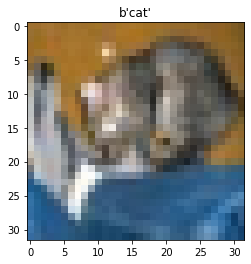

In [24]:
test_batch_fi = test_batchUpImgs[b'data'][0]
test_batch_fi = test_batch_fi.reshape(3, 32, 32)
test_batch_fi = test_batch_fi.transpose(1, 2, 0)
test_batch_fl = test_batchUpImgs[b'labels'][0]
plt.imshow(test_batch_fi)
plt.title(meta_data[b'label_names'][test_batch_fl])

Feature Extractor :

In [11]:
class FeatureExtractor: # for reference
    def __init__(self):
        base_model = VGG19(weights='imagenet') # find for VGG19
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

    def extract(self, img):
        img = img.resize((224, 224)) 
        img = img.convert('RGB')  
        x = image.img_to_array(img) 
        x = np.expand_dims(x, axis=0)  
        x = preprocess_input(x)  
        feature = self.model.predict(x)[0] 
        return feature / np.linalg.norm(feature)

In [87]:
# class FeatureExtractorSISE: # actual class used
#     def __init__(self):
#         base_model = VGG19(include_top=False, weights='imagenet', input_shape=(48,48,3))
#         self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)
        
#     def extractSISEQ(self, img):          # for query image 
#         img = img.resize((48,48))
#         img = img.convert('RGB')
#         z1 = image.img_to_array(img)
#         z2 = np.expand_dims(z1, axis=0)
#         z3 = preprocess_input(z2)                
#         feature = self.model.predict(z3)[0]       # (1, 4096) -> (4096,)
#         return feature/np.linalg.norm(feature)   # Normalizing
    
#     def extractSISED(self, dataset_img):   # for dataset images  
#         dataset_img = np.resize(dataset_img, (3,48,48))
#         dataset_img = dataset_img.transpose(1, 2, 0)
#         exp_dims_datasetimgs = np.expand_dims(dataset_img, axis=0)
#         pp_input_datasetimgs = preprocess_input(exp_dims_datasetimgs)                
#         feature_datasetimgs = self.model.predict(pp_input_datasetimgs)[0]       # (1, 4096) -> (4096,)
#         return feature_datasetimgs/np.linalg.norm(feature_datasetimgs)   # Normalizing

In [25]:
class FeatureExtractorSISE: # actual class used
    def __init__(self):
        base_model = VGG19(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
        
    def extractSISEQ(self, img):          # for query image 
#         img = img.resize((224, 224))
#         img = img.convert('RGB')
#         z1 = image.img_to_array(img)
        img = np.resize(img, (3, 224, 224))
        z1 = img.transpose(1, 2, 0)
        z2 = np.expand_dims(z1, axis=0)
        z3 = preprocess_input(z2)                
        feature = self.model.predict(z3)[0]       # (1, 4096) -> (4096,)
        return feature/np.linalg.norm(feature)   # Normalizing
    
    def extractSISED(self, dataset_img):   # for dataset images  
        dataset_img = np.resize(dataset_img, (3, 224, 224))
        dataset_img = dataset_img.transpose(1, 2, 0)
        exp_dims_datasetimgs = np.expand_dims(dataset_img, axis=0)
        pp_input_datasetimgs = preprocess_input(exp_dims_datasetimgs)                
        feature_datasetimgs = self.model.predict(pp_input_datasetimgs)[0]       # (1, 4096) -> (4096,)
        return feature_datasetimgs/np.linalg.norm(feature_datasetimgs)   # Normalizing

In [6]:
class FeatureExtractorM:  # Matsui's code
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)
        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)  # Normalize

In [26]:
# image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg' // external image used, from laptop 
# queryFeatures = FeatureExtractorSISE().extractSISEQ(img=pil.open(image_path_query))    # Features of Query Image
# print(queryFeatures)
# print(queryFeatures.shape)
# print(type(queryFeatures))

queryFeatures = FeatureExtractorSISE().extractSISEQ(test_batch[0])
print(queryFeatures)
print(queryFeatures.shape)
print(type(queryFeatures))

[0.         0.         0.00567609 ... 0.         0.         0.        ]
(4096,)
<class 'numpy.ndarray'>


In [ ]:
features = [] # for only databatch1, 10000 images from entire dataset
no = 0
for i in dataBatch1:
    datasetFeatures = FeatureExtractorSISE().extractSISED(dataBatch1[i, ])
    no = no+1
    print(no)
    features.append(datasetFeatures)

In [ ]:
featuresBatch2 = [] # for only databatch1, 10000 images from entire dataset
no = 0
for i in dataBatch2:
    datasetFeatures = FeatureExtractorSISE().extractSISED(dataBatch2[i, ])
    no = no+1
    print(no)
    features.append(datasetFeatures)

In [62]:
features = np.array(features)
print(features, features.shape)

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.00617675
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.00783338
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.00512905
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.

In [85]:
type(features[10])

numpy.ndarray

In [86]:
features[10].shape

(3, 3, 512)

Searching image dataset for query image & closest dist :

In [25]:
dists = np.linalg.norm(features-queryFeatures, axis=1) 
print(dists, dists.shape)

[[[0.         0.         0.         ... 0.         0.         0.02500442]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.00617675 0.02574723]]

 [[0.         0.         0.         ... 0.         0.00783338 0.02500442]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.00512905 0.02574723]]

 [[0.         0.         0.         ... 0.         0.01789575 0.02500442]
  [0.         0.         0.         ... 0.         0.00106738 0.01624876]
  [0.         0.         0.         ... 0.         0.03769569 0.02574723]]

 ...

 [[0.         0.         0.         ... 0.         0.00636981 0.02500442]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.03701076 0.02574723]]

 [[0.         0.         0.         ... 0.         0.         0.02500442]
  [0.         0.        

In [60]:
# dists = np.linalg.norm(features-queryFeatures, axis=1) 
ids = np.argsort(dists)[:3]  # Top 8 results
# scores = [dists[id] for id in ids]
# print(scores)
print(ids)

[[[  0 260 436 ... 259  53  30]
  [  0 278 277 ... 379  30  53]
  [  0 256 433 ... 259  53  30]]

 [[  0 266 265 ... 259  30  53]
  [  0 280 279 ... 506  30  53]
  [  0 264 263 ... 259  30  53]]

 [[  0 266 265 ... 455  30  53]
  [  0 283 453 ... 177  30  53]
  [  0 257 256 ... 259  53  30]]]


# ============= Rough Stuff =================

In [10]:
img_path = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
imgT = image.load_img(img_path, target_size=(224, 224))
i2a = image.img_to_array(imgT)
expD = np.expand_dims(i2a, axis=0)
pp = preprocess_input(expD)

In [ ]:
print(i2a, i2a.shape)

In [ ]:
res = np.resize(i2a, (224,224))
print(res, res.shape)

In [ ]:
expD

In [ ]:
pp

In [2]:
m = VGG19()
print(m.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

unp_imgs1 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
unp_imgs2 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_2")

In [ ]:
unp_imgs1

In [33]:
print(unp_imgs1[b'data'])

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]


In [34]:
print(unp_imgs2[b'data'])

[[ 35  27  25 ... 169 168 168]
 [ 20  20  18 ... 111  97  51]
 [116 115 155 ...  18  84 124]
 ...
 [127 139 155 ... 197 192 191]
 [190 200 208 ... 163 182 192]
 [177 174 182 ... 119 127 136]]


In [30]:
print(type(unp_imgs[b'data']), unp_imgs[b'data'].shape)

<class 'numpy.ndarray'> (10000, 3072)


In [38]:
np.append(unp_imgs1[b'data'], unp_imgs2[b'data'], axis=0)

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [127, 139, 155, ..., 197, 192, 191],
       [190, 200, 208, ..., 163, 182, 192],
       [177, 174, 182, ..., 119, 127, 136]], dtype=uint8)

In [3]:
M = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

NameError: name 'base_model' is not defined

In [2]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
img_op = Image.open(image_path_query)
img = img_op.resize((224, 224)) 
img = img.convert('RGB')  
x1 = image.img_to_array(img) 
x2 = np.expand_dims(x1, axis=0)  
x3 = preprocess_input(x2)  
feature = M.predict(x3)[0] 
ret = feature / np.linalg.norm(feature)

NameError: name 'M' is not defined

In [43]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
with pil.open(image_path_query) as im:
    rez = im.resize((224, 224))
print(rez)

<PIL.Image.Image image mode=RGB size=224x224 at 0x206EA777100>


In [57]:
class FeatureExtractorSISET:   
    def __init__(self):
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=(48,48,3))
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)
        
    def extractSISEQ(self, img):          # for query image 
        img = img.resize((224,224))
        img = img.convert('RGB')
        z1 = image.img_to_array(img)
        z2 = np.expand_dims(z1, axis=0)
        z3 = preprocess_input(z2)                
        feature = self.model.predict(z3)[0]       # (1, 4096) -> (4096,)
        return feature/np.linalg.norm(feature)   # Normalizing
    
    def extractSISED(self, dataset_img):   # for dataset images  
        dataset_img = np.resize(dataset_img, (3,48,48))
        dataset_img = dataset_img.transpose(1, 2, 0)
        exp_dims_datasetimgs = np.expand_dims(dataset_img, axis=0)
        pp_input_datasetimgs = preprocess_input(exp_dims_datasetimgs)                
        feature_datasetimgs = self.model.predict(pp_input_datasetimgs)[0]       # (1, 4096) -> (4096,)
        return feature_datasetimgs/np.linalg.norm(feature_datasetimgs)   # Normalizing

In [ ]:
print(d, d.shape)
im = np.resize(d, (3, 48, 48))
print(im, im.shape)
im = im.transpose(1, 2, 0)
print(im, im.shape)
exp = np.expand_dims(im, axis=0)
print(exp, exp.shape)
prepro = preprocess_input(im)
print(prepro, prepro.shape)

In [58]:
d = datasetImgs[1, ]
dFs = FeatureExtractorSISET().extractSISED(d)
print(dFs)
print(dFs.shape)

[[[0.         0.         0.         ... 0.         0.01395447 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.05115408 0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.02525747 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
(3, 3, 512)


In [ ]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
im1 = pil.open(image_path_query)
im1 = im1.resize((48, 48))
print(im1)
im1 = im1.convert('RGB')
print(im1)
z = image.img_to_array(im1)
print(z, z.shape)
z = np.expand_dims(z, axis=0)
print(z, z.shape)

In [20]:
arr = np.array([5,4,3,2,1])
np.argsort(arr)

array([4, 3, 2, 1, 0], dtype=int64)

In [21]:
arr[np.argsort(arr)]

array([1, 2, 3, 4, 5])

In [22]:
np.argsort(arr)[:3]

array([4, 3, 2], dtype=int64)

In [23]:
arr[np.argsort(arr)[:3]]

array([1, 2, 3])

In [ ]:
upImgs1

In [15]:
upImgs1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [14]:
upImgs1[b'labels'][0]

6

In [36]:
meta_data[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [11]:
meta_data

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

Text(0.5, 1.0, "b'frog'")

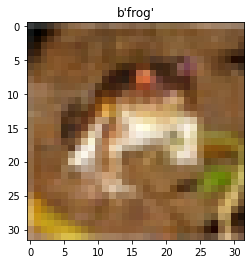

In [31]:
b1_fi = upImgs1[b'data'][0]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][0]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

In [32]:
upImgs1[b'data'][0].dtype

dtype('uint8')

In [48]:
labels = np.array(upImgs1[b'labels'])
label_names = np.array(meta_data[b'label_names'])
ImgLabelFeature = [(features[i], label_names[labels[i]]) for i in dataBatch1]

MemoryError: Unable to allocate 54.0 MiB for an array with shape (3072, 3, 3, 512) and data type float32

In [47]:
np.array(labels)[10000]

IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [ ]:
features = [] # for only databatch1, 10000 images from entire dataset
no = 0
ImgLabel = [] # consists images with corresponding feature and label
for i in dataBatch1:
    datasetFeatures = FeatureExtractorSISE().extractSISED(dataBatch1[i, ])
    no = no+1
    print(no)
    features.append(datasetFeatures)

In [ ]:
dists = np.linalg.norm(features-queryFeatures, axis=1) 
ids = np.argsort(dists)[:8]  # Top 8 results
scores = [dists[id] for id in ids]
print(scores)

In [53]:
array = [6, 1, 5, 2, 4, 3]
np.argsort(array)

array([1, 3, 5, 4, 2, 0], dtype=int64)

In [54]:
np.argsort(array)[:3]

array([1, 3, 5], dtype=int64)

In [32]:
arr1 = np.array([1,2,3,4,5])
dtype = [('index',int), ('feature',float)]
feat = [(1, features[0]), (2, 1.2), (3, 1.3), (4, 1.4)]
print(feat)

[(1, array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.00617675, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)), (2, 1.2), (3, 1.3), (4, 1.4)]


In [14]:
featr = [(1,features[0]), (2,features[1]), (3,features[2])]
# featrs = []
# for i in features:
#     featrs.append(features[i])

In [15]:
featr.sort(key=lambda i:i[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# featr = np.array([features[0], features[1], features[2], features[3], features[4]])

In [57]:
keys = [i for i in range(0,10000)]
values = features
myDict = dict(zip(keys,values))
print(myDict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [59]:
print(zip([1,2,3,4,5],[1,2,3,4,5]))

In [ ]:
a = np.array(feat, dtype=dtype)

In [ ]:
np.sort(a, order=['feature'])

In [14]:
features[3]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01963366],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [18]:
np.array([1.2,2.5,3,4,5]).dtype

dtype('float64')

In [19]:
features.dtype()

AttributeError: 'list' object has no attribute 'dtype'

==========================================

In [34]:
FeatureIndex = [(features[i], i) for i in range(0, 10000)] #list of (np arr, int)

In [35]:
FeatureIndex[2][0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [36]:
DistIndex = [(np.linalg.norm(FeatureIndex[i][0]-queryFeatures), i) for i in range(0, 10000)] #list of (float, int)

In [37]:
DistIndex

[(0.92842287, 0),
 (0.9881951, 1),
 (0.7160374, 2),
 (0.90834415, 3),
 (0.86938983, 4),
 (0.88626695, 5),
 (0.88551724, 6),
 (0.9130107, 7),
 (0.95709413, 8),
 (1.0192285, 9),
 (0.87228, 10),
 (1.0155907, 11),
 (0.93898773, 12),
 (0.82252413, 13),
 (0.8478705, 14),
 (0.86813545, 15),
 (0.91991264, 16),
 (0.9258861, 17),
 (0.90076643, 18),
 (0.8580169, 19),
 (0.96887964, 20),
 (1.0339993, 21),
 (1.0261989, 22),
 (0.9574312, 23),
 (0.93553877, 24),
 (0.9227792, 25),
 (1.0014157, 26),
 (0.8491726, 27),
 (0.9796368, 28),
 (0.9157693, 29),
 (1.0498672, 30),
 (0.8264513, 31),
 (0.93194133, 32),
 (0.90895855, 33),
 (0.8591085, 34),
 (0.95869476, 35),
 (0.90961313, 36),
 (0.96272284, 37),
 (0.8623279, 38),
 (0.85862416, 39),
 (0.9822097, 40),
 (0.9114773, 41),
 (0.8420463, 42),
 (0.9131207, 43),
 (0.9640851, 44),
 (0.92655283, 45),
 (0.9292163, 46),
 (0.95956933, 47),
 (0.9152781, 48),
 (0.8660216, 49),
 (0.8932175, 50),
 (0.9466315, 51),
 (0.9249391, 52),
 (0.8311083, 53),
 (0.87457883, 54),


In [17]:
DistIndex.shape

AttributeError: 'list' object has no attribute 'shape'

In [38]:
Dists_only = [(DistIndex[i][0]) for i in range(0, 10000)]

In [ ]:
Dists_only

In [40]:
Dists_only = np.asarray(Dists_only)
Dists_only

array([0.92842287, 0.9881951 , 0.7160374 , ..., 0.98775613, 0.8804952 ,
       1.0019138 ], dtype=float32)

In [41]:
sorted_Dists_only = np.argsort(Dists_only)

In [42]:
sorted_Dists_only.shape

(10000,)

In [43]:
sorted_Dists_only

array([2814, 9221, 4688, ..., 3409, 4169, 8919], dtype=int64)

In [44]:
for i in range(0, 8):
    print(sorted_Dists_only[i], Dists_only[sorted_Dists_only[i]])

2814 0.5213002
9221 0.57640857
4688 0.5900769
1977 0.6031929
6329 0.6077309
1787 0.6165984
5010 0.61733526
7531 0.61929125


In [47]:
print(Dists_only[2814])
print(Dists_only[9221])
print(Dists_only[4688])
print(Dists_only[1977])
print(Dists_only[6329])
print(Dists_only[1787])
print(Dists_only[5010])
print(Dists_only[7531])

0.5213002
0.57640857
0.5900769
0.6031929
0.6077309
0.6165984
0.61733526
0.61929125


In [19]:
print(Dists_only[9984])

1.312777


Text(0.5, 1.0, "b'horse'")

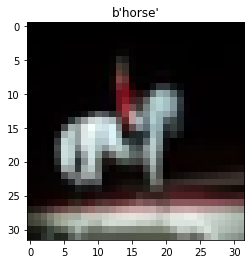

In [48]:
b1_fi = upImgs1[b'data'][2814]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][2814]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

Text(0.5, 1.0, "b'airplane'")

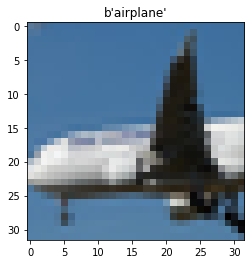

In [49]:
b1_fi = upImgs1[b'data'][9221]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][9221]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

Text(0.5, 1.0, "b'horse'")

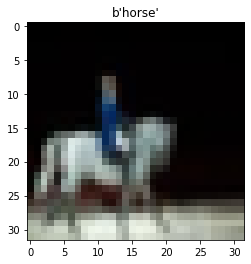

In [50]:
b1_fi = upImgs1[b'data'][4688]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][4688]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

Text(0.5, 1.0, "b'airplane'")

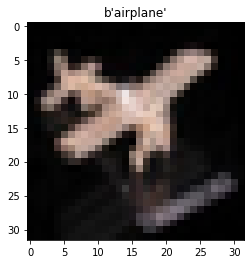

In [51]:
b1_fi = upImgs1[b'data'][1977]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][1977]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

Text(0.5, 1.0, "b'horse'")

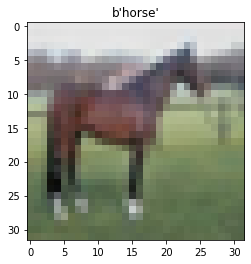

In [52]:
b1_fi = upImgs1[b'data'][6329]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][6329]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

In [24]:
FeatureDict = {}
for i in range(0, 10000):
    FeatureDict[i] = Dists_only[i] 

In [ ]:
FeatureDict

In [26]:
keysList = list(FeatureDict.keys())

In [ ]:
keysList

In [27]:
valuesList = list(FeatureDict.values())

In [ ]:
valuesList

In [28]:
sorted_Dists_only

array([1875, 4327, 3587, ..., 5014, 1787, 9984], dtype=int64)

In [80]:
Dists_only

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.00617675, 0.03793778],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01062487]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.00936317, 0.03793778],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01062487]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.04174161, 0.03793778],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01062487]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.03755491, 0.03793778],
        [0.        , 

In [ ]:
[(Dists_only[sorted_Dists_only[i]], valuesList) for i in sorted_Dists_only]

In [81]:
Dists2 = [np.linalg.norm(features-queryFeatures, axis=1)]
print(Dists2)

[array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.02500442],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01624876],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.00617675, 0.02574723]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.00783338, 0.02500442],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01624876],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.00512905, 0.02574723]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.01789575, 0.02500442],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.00106738, 0.01624876],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.03769569, 0.02574723]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.00636981, 0.02500442],
        [0.        ,

In [82]:
ids = np.argsort(Dists2)[:10]

In [83]:
Dists2[ids[0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [84]:
for i in ids:
    print(Dists2[i])

TypeError: only integer scalar arrays can be converted to a scalar index

In [26]:
FeatureDict[str(Dists_only[9999])]

9999

In [ ]:
Dists_only[sorted_Dists_only[0]]

In [44]:
valuesList[Dists_only[sorted_Dists_only[0]]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [42]:
scores = [(Dists_only[i], valuesList[Dists_only[i]]) for i in sorted_Dists_only]
print(scores)

TypeError: only integer scalar arrays can be converted to a scalar index

In [78]:
Dists_only.shape

(10000, 3, 512)

In [79]:
sorted_Dists_only.shape

(10000, 3, 512)

In [82]:
Dists_only[sorted_Dists_only[0]].shape

(3, 512, 3, 512)

In [ ]:
FeatureDict[str(Dists_only[sorted_Dists_only[0]])]

In [51]:
Dists_only.shape

(10000, 3, 512)

In [52]:
sorted_Dists_only.shape

(10000, 3, 512)

In [32]:
top8_sorted_DistIndex = sorted_DistIndex[:8]

In [44]:
for i in range(0, 8):
    print(top8_sorted_DistIndex[i,:,:,1])

[[0 275 273 ... 259 177 30]
 [0 329 327 ... 177 53 30]
 [0 510 426 ... 344 76 53]]
[[0 286 284 ... 53 177 30]
 [0 330 329 ... 177 30 53]
 [0 426 258 ... 259 76 53]]
[[0 277 276 ... 455 177 30]
 [0 331 330 ... 177 30 53]
 [0 262 261 ... 259 76 53]]
[[0 273 272 ... 379 177 30]
 [0 327 326 ... 379 177 30]
 [0 258 421 ... 259 76 53]]
[[0 272 465 ... 57 177 30]
 [0 333 332 ... 53 30 506]
 [0 419 421 ... 53 506 259]]
[[0 280 279 ... 282 177 30]
 [0 332 331 ... 177 282 30]
 [0 260 422 ... 259 76 53]]
[[0 283 466 ... 259 177 30]
 [0 330 329 ... 53 177 30]
 [0 421 257 ... 53 58 76]]
[[0 284 283 ... 379 177 30]
 [0 332 331 ... 177 53 30]
 [0 258 424 ... 259 76 53]]


In [28]:
top8_sorted_DistIndex.shape

(8, 3, 512, 2)

In [29]:
top8_sorted_DistIndex[0].shape

(3, 512, 2)

In [ ]:
top8_sorted_DistIndex[0][0]

In [ ]:
top8_sorted_DistIndex[0][2]

In [ ]:
Dist = [np.linalg.norm(features[i]-queryFeatures, axis=1) for i in range(0, 10000)] #list of float
Dist

In [36]:
np.array(Dist).shape

(10000, 3, 512)

In [11]:
Dist = np.array(Dist)
ids = np.argsort(Dist)[:8]
scr = [Dist[it] for it in ids]

In [22]:
Dist.shape

(10000, 3, 512)

In [26]:
Dist1 = [np.linalg.norm(features[i]-queryFeatures, axis=1) for i in range(0, 10000)]

In [28]:
if scr[0][0][0] in Dist1:
    print('T')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [43]:
scr1 = Dist[ids[0]]
scr1[:,:,0,0].shape

(3, 512)

In [20]:
f = features[np.where(features==scr[0])]
print(f.shape, Dist.shape)

C:\Users\Tejas\AppData\Local\Temp\ipykernel_24484\3119239039.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  f = features[np.where(features==scr[0])]


TypeError: list indices must be integers or slices, not tuple

In [21]:
print(np.where(features==Dist[0]))

(array([   0,    0,    0, ..., 9999, 9999, 9999], dtype=int64), array([0, 0, 0, ..., 2, 2, 2], dtype=int64), array([0, 0, 0, ..., 2, 2, 2], dtype=int64), array([  0,   1,   2, ..., 508, 509, 510], dtype=int64))


In [44]:
for i in range(0, 10000):
    cmp = (Dist[i] == scr1[:,:,0,0])
    if (cmp.all()):
        print(i)

In [37]:
Dist[0].shape

(3, 512)

In [38]:
scr[0][:,:,0,0].shape

(3, 512)

In [34]:
scr[0][:,:,0,0] == Dist[0]

array([[ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [27]:
scr[0].transpose(0, 2, 1, 3).shape

(3, 3, 512, 512)

In [19]:
a = np.array([[1,2.2,3,4], [5,6,7.3,8]])
b = np.array([[5,6.7,7,8], [10,11.6,12,13]])
for i in range(0, 2):
    c = (a[i] == b[0])
    if (c.all()):
        print(a.shape, b.shape, c.all())

In [21]:
c.dtype

dtype('bool')

In [30]:
a[0]

array([1. , 2.2, 3. , 4. ])

Text(0.5, 1.0, "b'truck'")

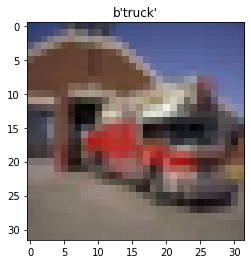

In [40]:
b1_fi = upImgs1[b'data'][273]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][273]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])